In [27]:
import os
import pickle
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import matplotlib.pyplot as plt
from typing import *

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

In [14]:
pg_auth = os.environ.get("PG_AUTH")

conn = psycopg2.connect(host="localhost",
                        user="postgres",
                        dbname="investment_db",
                        password=pg_auth)

cur = conn.cursor()
cur.execute("SELECT * FROM stock_price")
rows = cur.fetchall()

# Query data
df = psql.read_sql('''
                    SELECT * FROM stock_price
                    where date::date < '2021-04-16'
                   ''', conn)
names = df['name'].unique()

In [18]:
df.head()

,id,date,name,price,delta_price,delta_price_perc,top_3_news,news_source
0,1,2020-12-28 08:00:03,"Uber Technologies, Inc. (UBER)",52.88,-0.83,-1.55,"{""China Shows Jack Ma What an Activist Can Do""...","{Bloomberg,Benzinga,""Yahoo Finance""}"
1,2,2020-12-28 08:00:03,Twilio Inc. (TWLO),362.88,-0.40,-0.11,"{""Is Twilio Stock A Buy Now After 435% Surge?""...","{""Investor's Business Daily"",Zacks,""Motley Fool""}"
2,3,2020-12-28 08:00:03,"Chegg, Inc. (CHGG)",92.41,-0.67,-0.72,"{""These Are The 5 Best Stocks To Buy And Watch...","{""Motley Fool"",""Investor's Business Daily"",Zacks}"
3,4,2020-12-28 08:00:03,Alphabet Inc. (GOOGL),1734.16,5.93,0.34,"{""Alphabet Is One of Barron’s Top Stock Picks ...","{Barrons.com,Barrons.com,MarketWatch}"
4,5,2020-12-28 08:00:03,Zynga Inc. (ZNGA),9.91,-0.02,-0.20,"{""Black Eyed Peas Encourage Fans to #PlayApart...","{""Business Wire"",Zacks,Barrons.com}"


In [17]:
[i for i in names]

['Uber Technologies, Inc. (UBER)',
 'Twilio Inc. (TWLO)',
 'Chegg, Inc. (CHGG)',
 'Alphabet Inc. (GOOGL)',
 'Zynga Inc. (ZNGA)',
 'Etsy, Inc. (ETSY)',
 'United Airlines Holdings, Inc. (UAL)',
 'GoHealth, Inc. (GOCO)',
 'Shopify Inc. (SHOP)',
 'Tesla, Inc. (TSLA)',
 'Chipotle Mexican Grill, Inc. (CMG)']

In [32]:
comp_df = df[df['name']=='Uber Technologies, Inc. (UBER)']
comp_df.shape

(679, 8)

In [33]:
comp_df.isna().sum()

id                  0
date                0
name                0
price               0
delta_price         0
delta_price_perc    0
top_3_news          0
news_source         0
dtype: int64

In [52]:
# Get simple moving average (SMA)
def sma(data: pd.DataFrame, colName: str, period: int) -> list:

    temp = []
    for i in range(period, len(data[colName])):
        sma = round(data[colName][i-period:i].mean(),2)
        temp.append(sma)

    return [0 if i < period else temp[i-period] for i in range(len(data[colName]))]

# Get exponential moving average (EMA)
def ema(data: pd.DataFrame, colName: str, period: int) -> list:

    alpha = 2/(period+1)
    sma_1 = sma(data, colName, period)
    temp = []

    for i in range(period, len(data[colName])):
        ema = (sum(data[colName][i:i+1])*alpha) + ((1-alpha)*sma_1[i-1])
        temp.append(ema)

    return [0 if i < period else temp[i-period] for i in range(len(data[colName]))]

# Get weighted moving average (WMA)
def wma(data: pd.DataFrame, colName: str, period: int) -> list:

    denom = (period*(period+1))/2
    temp = []

    for i in range(period, len(data[colName])):

        time_window = [i for i in data[colName][i-period:i]]
        weighted = []

        for j in range(len(time_window)):

            weighted.append(time_window[j] * (j+1))

        weighted_sum = round(sum(weighted)/denom, 2)
        temp.append(weighted_sum)

    return [0 if i < period else temp[i-period] for i in range(len(data[colName]))]

In [604]:
n=24

simple_ma = sma(comp_df, 'price', n)
x = [i for i in range(len(simple_ma))]

In [605]:
ma_df = pd.DataFrame({'x': x, 
                      'simple_ma':simple_ma, 
                      'stock_price':comp_df.price})
ma_df

,x,simple_ma,stock_price
0,0,0.00,52.88
15,1,0.00,52.59
27,2,0.00,52.02
37,3,0.00,52.15
51,4,0.00,51.97
...,...,...,...
7411,674,59.90,60.12
7427,675,60.00,59.65
7433,676,60.08,59.40
7451,677,60.08,59.23


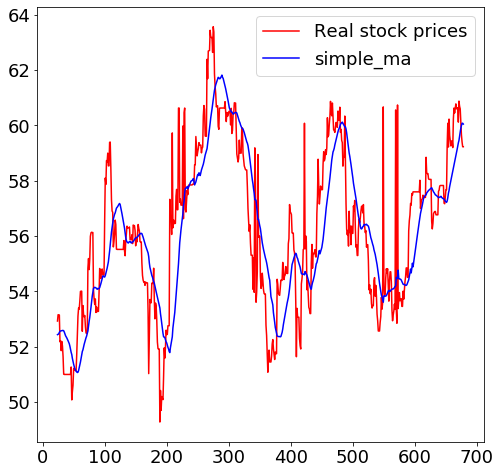

In [606]:
plt.plot(ma_df.x[n:], ma_df.stock_price[n:], color='red', label='Real stock prices')
plt.plot(ma_df.x[n:], ma_df.simple_ma[n:], color='blue', label='simple_ma')
plt.legend()
plt.show()

,K,MAE,MSE
0,0,0.127606,0.022031
1,1,0.032374,0.001499
2,2,0.015676,0.000494
3,3,0.015676,0.000494
4,4,0.015295,0.000361
5,5,0.007656,0.000108
6,6,0.005682,0.000074
7,7,0.005682,0.000074
8,8,0.005850,0.000061
9,9,0.003708,0.000028


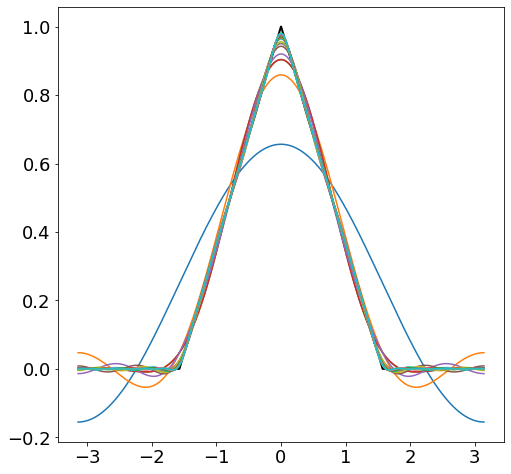

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Define domain
dx = 0.001
L = np.pi
x = L * np.arange(-1+dx,1+dx,dx)
n = len(x)
nquart = int(np.floor(n/4))

# Define hat function
f = np.zeros_like(x)
f[nquart:2*nquart] = (4/n)*np.arange(1,nquart+1)
f[2*nquart:3*nquart] = np.ones(nquart) - (4/n)*np.arange(0,nquart)

fig, ax = plt.subplots()
ax.plot(x,f,'-',color='k',LineWidth=2)

# Compute Fourier series
name = "Accent"
cmap = get_cmap('tab10')
colors = cmap.colors
ax.set_prop_cycle(color=colors)

A0 = np.sum(f * np.ones_like(x)) * dx
fFS = A0/2

ft = []

A = np.zeros(20)
B = np.zeros(20)
for k in range(20):
    A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx # Inner product
    B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
    fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin((k+1)*np.pi*x/L)
    ft.append([k, mae(f, fFS), mse(f, fFS)])
    ax.plot(x,fFS,'-')
    
ft = pd.DataFrame(ft, columns=['K', 'MAE', 'MSE'])
ft[ft['MAE']==min(ft['MAE'])]
ft[ft['MSE']==min(ft['MSE'])]
ft


# Period 1

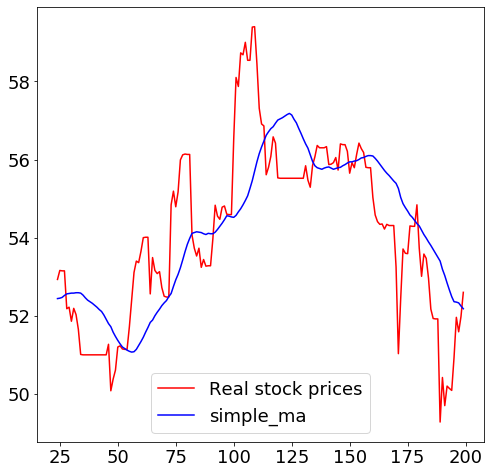

In [607]:
period_1 = ma_df[n:200]

plt.plot(period_1.x, period_1.stock_price, color='red', label='Real stock prices')
plt.plot(period_1.x, period_1.simple_ma, color='blue', label='simple_ma')
plt.legend()
plt.show()

     K        MAE          MSE
0    0  45.511460  2073.701448
1    1  45.511460  2073.584624
2    2  45.106376  2037.595157
3    3  45.106376  2037.566268
4    4  44.954850  2023.581093
5    5  44.954850  2023.591384
6    6  44.878348  2016.602284
7    7  44.878348  2016.582502
8    8  44.831443  2012.241684
9    9  44.831443  2012.246814
10  10  44.800403  2009.413951
11  11  44.800403  2009.418444
12  12  44.778336  2007.423022
13  13  44.778336  2007.425747
14  14  44.761777  2005.932499
15  15  44.761777  2005.934165
16  16  44.748950  2004.785900
17  17  44.748950  2004.784458
18  18  44.738490  2003.832159
19  19  44.738490  2003.831867 

176


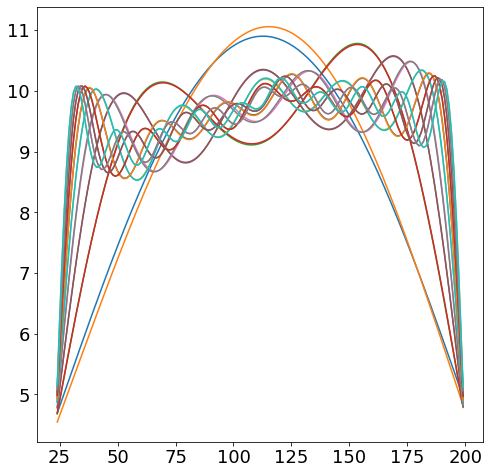

In [608]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Define domain
dx = 0.001
L = 200-n
x = period_1.x
n = len(x)
nquart = n

# Define hat function
f = period_1.simple_ma

fig, ax = plt.subplots()
# ax.plot(x,f-49,'-',color='k',LineWidth=2)

# Compute Fourier series
name = "Accent"
cmap = get_cmap('tab10')
colors = cmap.colors
ax.set_prop_cycle(color=colors)

A0 = np.sum(f * np.ones_like(x)) * dx
fFS = A0/2

ft_track = []
fts = []

A = np.zeros(20)
B = np.zeros(20)
for k in range(20):
    A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx # Inner product
    B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
    fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin((k+1)*np.pi*x/L)
    ft_track.append([k, mae(f, fFS), mse(f, fFS)])
    fts.append(fFS)
    ax.plot(x,fFS,'-')
    
ft_track = pd.DataFrame(ft_track, columns=['K', 'MAE', 'MSE'])
ft_track[ft_track['MAE']==min(ft_track['MAE'])]
ft_track[ft_track['MSE']==min(ft_track['MSE'])]
print(ft_track,'\n')
print(len(fts[0]))


In [609]:
def get_k(L):
    
    temp_list = []

    for i in range(5000):

        sum_list = [5]*L
        k_list=[]
        for i in range(5):
            k=random.randint(0,19)
            sum_list = [a+b for a, b in zip(sum_list, fts[k])]
            k_list.append(k)
        MSE = mse(period_1.simple_ma[10:-10], sum_list[10:-10])
        MAE = mae(period_1.simple_ma[10:-10], sum_list[10:-10])
        temp_list.append([MSE, MAE, k_list])

    return temp_list

In [612]:
random.seed(10)

temp_list = get_k(L)          
temp_df_1 = pd.DataFrame(temp_list, columns=['MSE', 'MAE', 'K-List'])
temp_df_1

print(temp_df_1[temp_df_1['MSE']==min(temp_df_1['MSE'])])
k_list = temp_df_1.loc[temp_df_1['MSE']==min(temp_df_1['MSE']), 'K-List']
k_list = list(k_list)
k_list = k_list[0]
k_list

           MSE       MAE              K-List
4670  2.147341  1.325729  [11, 4, 14, 19, 9]


[11, 4, 14, 19, 9]

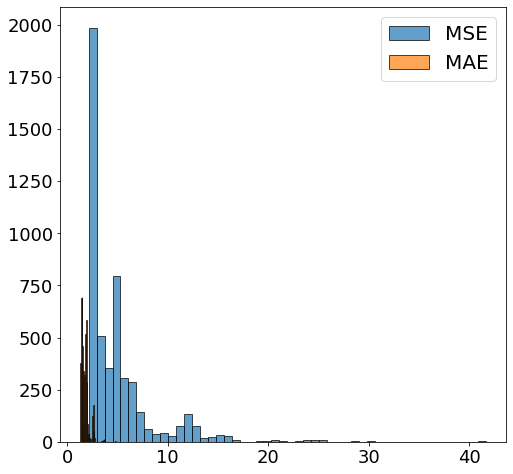

In [613]:
plt.hist(temp_df_1['MSE'], edgecolor='black', bins=50, alpha=0.7, label='MSE')
plt.hist(temp_df_1['MAE'], edgecolor='black', bins=50, alpha=0.7, label='MAE')
plt.legend(loc='upper right', fontsize=20)
plt.show()

In [614]:
sum_list = [5]*176
for i in k_list:
    sum_list = [a+b for a, b in zip(sum_list, fts[i])]

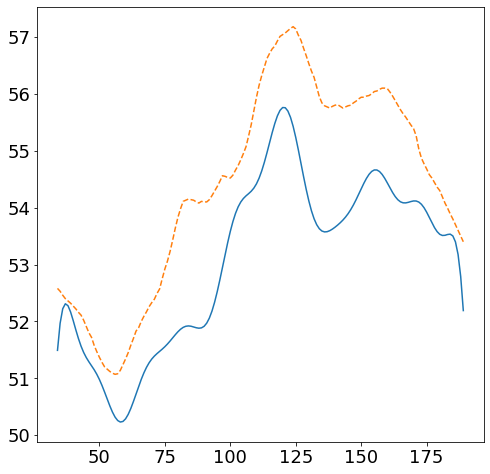

In [615]:
N=10

fig, ax = plt.subplots()
ax.plot(period_1.x[N:-N], sum_list[N:-N],'-')
ax.plot(period_1.x[N:-N], period_1.simple_ma[N:-N],'--')

# Period 2

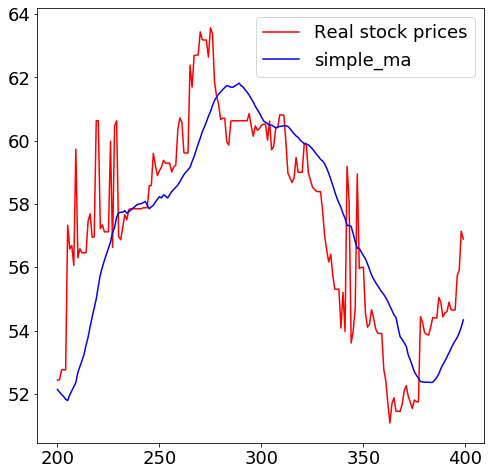

In [616]:
period_2 = ma_df[200:400]

plt.plot(period_2.x, period_2.stock_price, color='red', label='Real stock prices')
plt.plot(period_2.x, period_2.simple_ma, color='blue', label='simple_ma')
plt.legend()
plt.show()

     K        MAE          MSE
0    0  46.777022  2189.625878
1    1  46.777022  2189.219561
2    2  46.323613  2150.366864
3    3  46.323613  2150.390493
4    4  46.154005  2135.268818
5    5  46.154005  2135.294617
6    6  46.068452  2127.718384
7    7  46.068452  2127.718280
8    8  46.018762  2123.543119
9    9  46.018762  2123.506950
10  10  45.983438  2120.351046
11  11  45.983438  2120.334103
12  12  45.958153  2118.080540
13  13  45.958153  2118.066487
14  14  45.938810  2116.310517
15  15  45.938810  2116.306644
16  16  45.923803  2114.951035
17  17  45.923803  2114.948387
18  18  45.911724  2113.852207
19  19  45.911724  2113.851842 

200


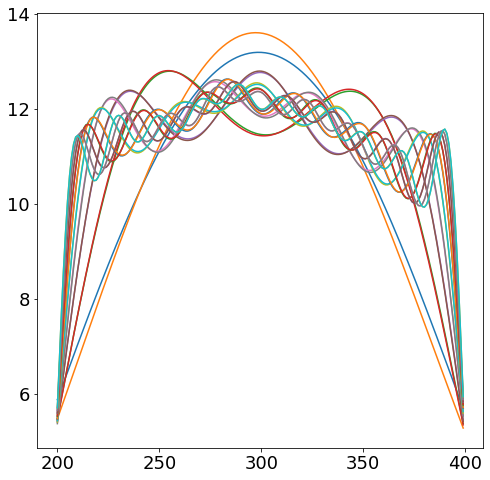

In [617]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Define domain
dx = 0.001
L = 200
x = period_2.x
n = len(x)
nquart = n

# Define hat function
f = period_2.simple_ma

fig, ax = plt.subplots()
# ax.plot(x,f-49,'-',color='k',LineWidth=2)

# Compute Fourier series
name = "Accent"
cmap = get_cmap('tab10')
colors = cmap.colors
ax.set_prop_cycle(color=colors)

A0 = np.sum(f * np.ones_like(x)) * dx
fFS = A0/2

ft_track = []
fts = []

A = np.zeros(20)
B = np.zeros(20)
for k in range(20):
    A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx # Inner product
    B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
    fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin((k+1)*np.pi*x/L)
    ft_track.append([k, mae(f, fFS), mse(f, fFS)])
    fts.append(fFS)
    ax.plot(x,fFS,'-')
    
ft_track = pd.DataFrame(ft_track, columns=['K', 'MAE', 'MSE'])
ft_track[ft_track['MAE']==min(ft_track['MAE'])]
ft_track[ft_track['MSE']==min(ft_track['MSE'])]
print(ft_track,'\n')
print(len(fts[0]))


In [618]:
def get_k(L):
    
    temp_list = []

    for i in range(5000):

        sum_list = [0]*L
        k_list=[]
        for i in range(5):
            k=random.randint(0,19)
            sum_list = [a+b for a, b in zip(sum_list, fts[k])]
            k_list.append(k)
        MSE = mse(period_2.simple_ma[10:-10], sum_list[10:-10])
        MAE = mae(period_2.simple_ma[10:-10], sum_list[10:-10])
        temp_list.append([MSE, MAE, k_list])

    return temp_list

In [619]:
random.seed(10)

temp_list = get_k(L)          
temp_df_2 = pd.DataFrame(temp_list, columns=['MSE', 'MAE', 'K-List'])
# print(temp_df)

print(temp_df_2[temp_df_2['MSE']==min(temp_df_2['MSE'])])
k_list = temp_df_2.loc[temp_df_2['MSE']==min(temp_df_2['MSE']), 'K-List']
k_list = list(k_list)
k_list = k_list[0]
k_list

           MSE       MAE              K-List
1778  0.368468  0.503218  [4, 13, 9, 18, 16]


[4, 13, 9, 18, 16]

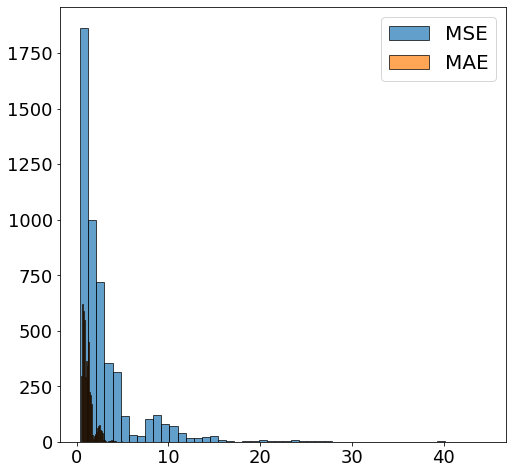

In [620]:
plt.hist(temp_df_2['MSE'], edgecolor='black', bins=50, alpha=0.7, label='MSE')
plt.hist(temp_df_2['MAE'], edgecolor='black', bins=50, alpha=0.7, label='MAE')
plt.legend(loc='upper right', fontsize=20)
plt.show()

In [621]:
sum_list = [0]*L
for i in k_list:
    sum_list = [a+b for a, b in zip(sum_list, fts[i])]

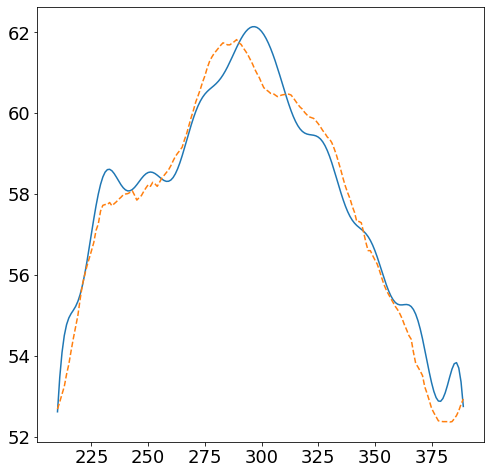

In [622]:
N=10

fig, ax = plt.subplots()
ax.plot(period_2.x[N:-N], sum_list[N:-N],'-')
ax.plot(period_2.x[N:-N], period_2.simple_ma[N:-N],'--')

# Period 3

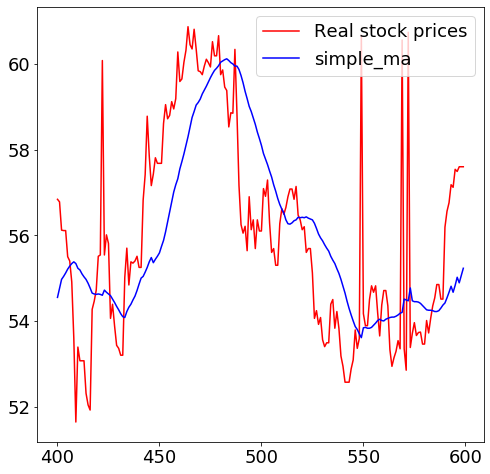

In [623]:
period_3 = ma_df[400:600]

plt.plot(period_3.x, period_3.stock_price, color='red', label='Real stock prices')
plt.plot(period_3.x, period_3.simple_ma, color='blue', label='simple_ma')
plt.legend()
plt.show()

     K        MAE          MSE
0    0  45.762529  2097.083236
1    1  45.762529  2097.200511
2    2  45.302302  2057.232706
3    3  45.302302  2056.951758
4    4  45.123804  2040.245315
5    5  45.123804  2040.159420
6    6  45.028970  2030.909841
7    7  45.028970  2030.933542
8    8  44.974916  2025.980011
9    9  44.974916  2025.967666
10  10  44.938151  2022.545751
11  11  44.938151  2022.537837
12  12  44.911311  2019.992389
13  13  44.911311  2019.994346
14  14  44.891432  2018.137964
15  15  44.891432  2018.137529
16  16  44.875964  2016.696569
17  17  44.875964  2016.693289
18  18  44.863366  2015.500217
19  19  44.863366  2015.498804 

200


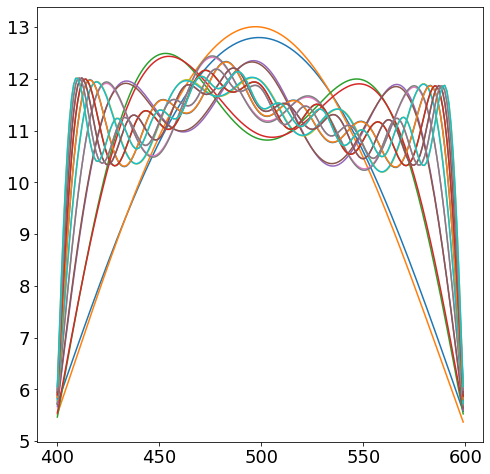

In [624]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

# Define domain
dx = 0.001
L = 200
x = period_3.x
n = len(x)
nquart = n

# Define hat function
f = period_3.simple_ma

fig, ax = plt.subplots()
# ax.plot(x,f-49,'-',color='k',LineWidth=2)

# Compute Fourier series
name = "Accent"
cmap = get_cmap('tab10')
colors = cmap.colors
ax.set_prop_cycle(color=colors)

A0 = np.sum(f * np.ones_like(x)) * dx
fFS = A0/2

ft_track = []
fts = []

A = np.zeros(20)
B = np.zeros(20)
for k in range(20):
    A[k] = np.sum(f * np.cos(np.pi*(k+1)*x/L)) * dx # Inner product
    B[k] = np.sum(f * np.sin(np.pi*(k+1)*x/L)) * dx
    fFS = fFS + A[k]*np.cos((k+1)*np.pi*x/L) + B[k]*np.sin((k+1)*np.pi*x/L)
    ft_track.append([k, mae(f, fFS), mse(f, fFS)])
    fts.append(fFS)
    ax.plot(x,fFS,'-')
    
ft_track = pd.DataFrame(ft_track, columns=['K', 'MAE', 'MSE'])
ft_track[ft_track['MAE']==min(ft_track['MAE'])]
ft_track[ft_track['MSE']==min(ft_track['MSE'])]
print(ft_track,'\n')
print(len(fts[0]))


In [625]:
def get_k(L):
    
    temp_list = []

    for i in range(5000):

        sum_list = [0]*L
        k_list=[]
        for i in range(5):
            k=random.randint(0,19)
            sum_list = [a+b for a, b in zip(sum_list, fts[k])]
            k_list.append(k)
        MSE = mse(period_3.simple_ma[10:-10], sum_list[10:-10])
        MAE = mae(period_3.simple_ma[10:-10], sum_list[10:-10])
        temp_list.append([MSE, MAE, k_list])

    return temp_list

In [626]:
random.seed(10)

temp_list = get_k(L)          
temp_df_3 = pd.DataFrame(temp_list, columns=['MSE', 'MAE', 'K-List'])
print(temp_df_3)

print(temp_df_3[temp_df_3['MSE']==min(temp_df_3['MSE'])])
k_list = temp_df_3.loc[temp_df_3['MSE']==min(temp_df_3['MSE']), 'K-List']
k_list = list(k_list)
k_list = k_list[0]
k_list

            MSE       MAE               K-List
0      2.863632  1.288859  [18, 1, 13, 15, 18]
1      1.834657  1.175040    [0, 6, 14, 15, 8]
2      2.739113  1.231683   [5, 1, 16, 15, 10]
3      4.496413  1.479265    [2, 7, 11, 1, 13]
4      0.751478  0.697401  [4, 19, 11, 12, 13]
...         ...       ...                  ...
4995   0.948075  0.836006   [17, 18, 6, 14, 2]
4996   2.076151  1.238729   [11, 1, 6, 18, 13]
4997   7.016411  1.595558    [2, 0, 19, 18, 5]
4998  15.288173  2.785988      [3, 6, 0, 1, 8]
4999   1.592659  0.929742    [10, 8, 7, 16, 7]

[5000 rows x 3 columns]
           MSE       MAE              K-List
1806  0.445706  0.565357  [9, 16, 5, 12, 18]


[9, 16, 5, 12, 18]

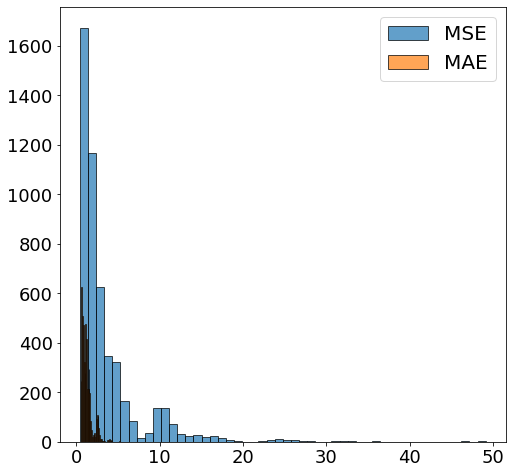

In [627]:
plt.hist(temp_df_3['MSE'], edgecolor='black', bins=50, alpha=0.7, label='MSE')
plt.hist(temp_df_3['MAE'], edgecolor='black', bins=50, alpha=0.7, label='MAE')
plt.legend(loc='upper right', fontsize=20)
plt.show()

In [628]:
sum_list = [0]*L
for i in k_list:
    sum_list = [a+b for a, b in zip(sum_list, fts[i])]

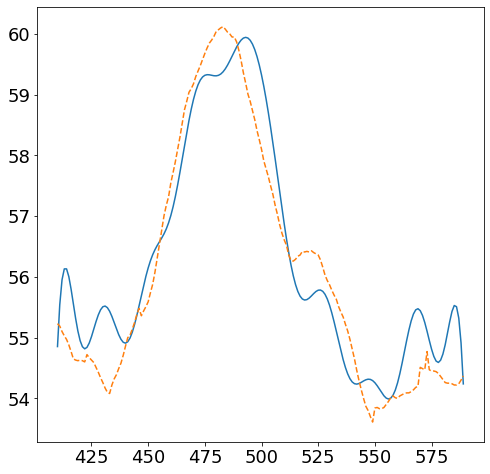

In [629]:
N=10

fig, ax = plt.subplots()
ax.plot(period_3.x[N:-N], sum_list[N:-N],'-')
ax.plot(period_3.x[N:-N], period_3.simple_ma[N:-N],'--')

In [630]:
sum_list = [0]*L
k_list = [17, 9, 12]
for i in k_list:
    sum_list = [a+b for a, b in zip(sum_list, fts[i])]

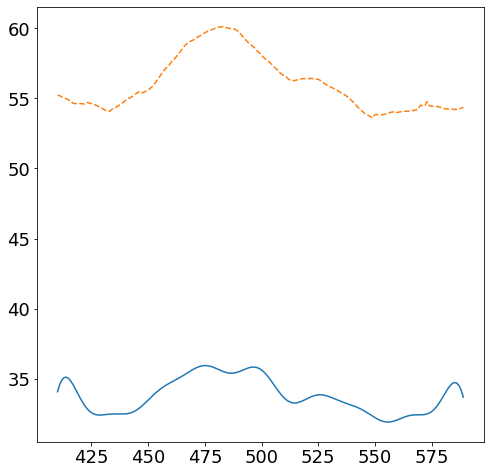

In [443]:
N=10

fig, ax = plt.subplots()
ax.plot(period_3.x[N:-N], sum_list[N:-N],'-')
ax.plot(period_3.x[N:-N], period_3.simple_ma[N:-N],'--')

In [435]:
sum_list = [0]*L
k_list = [18, 5]
for i in k_list:
    sum_list = [a+b for a, b in zip(sum_list, fts[i])]

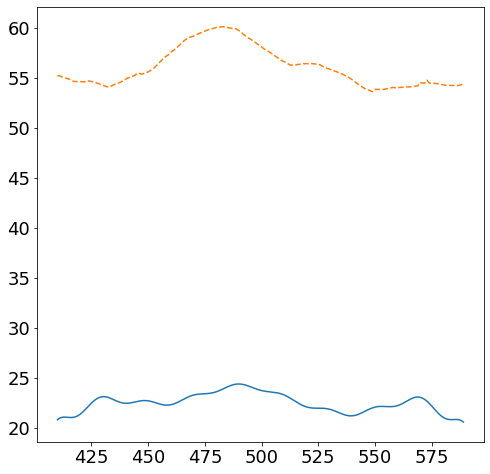

In [436]:
N=10

fig, ax = plt.subplots()
ax.plot(period_3.x[N:-N], sum_list[N:-N],'-')
ax.plot(period_3.x[N:-N], period_3.simple_ma[N:-N],'--')

In [556]:
temp_df_1_optimized = temp_df_1[temp_df_1['MSE']<=3]
temp_df_2_optimized = temp_df_2[temp_df_2['MSE']<=3]
temp_df_3_optimized = temp_df_3[temp_df_3['MSE']<=3]

print(temp_df_1_optimized.shape, temp_df_2_optimized.shape, temp_df_3_optimized.shape)

(2076, 3) (3646, 3) (3343, 3)


In [563]:
temp_df_1_optimized

,MSE,MAE,K-List
4,2.336204,1.354851,"[4, 19, 11, 12, 13]"
5,2.667590,1.416508,"[9, 8, 14, 5, 9]"
6,2.248984,1.317894,"[11, 4, 14, 7, 14]"
8,2.949686,1.565316,"[7, 4, 6, 9, 17]"
9,2.421533,1.454217,"[11, 7, 10, 17, 14]"
...,...,...,...
4988,2.327059,1.344897,"[8, 10, 16, 6, 18]"
4992,2.480152,1.441372,"[17, 4, 15, 15, 6]"
4993,2.728303,1.452016,"[17, 18, 6, 17, 6]"
4995,2.937844,1.503131,"[17, 18, 6, 14, 2]"


In [596]:
sorted_1 = [sorted(list(i)) for i in temp_df_1_optimized['K-List']]
sorted_2 = [sorted(list(i)) for i in temp_df_2_optimized['K-List']]
sorted_3 = [sorted(list(i)) for i in temp_df_3_optimized['K-List']]

In [597]:
sorted_1 = [int(item) for sublist in sorted_1 for item in sublist]
sorted_2 = [int(item) for sublist in sorted_2 for item in sublist]
sorted_3 = [int(item) for sublist in sorted_3 for item in sublist]

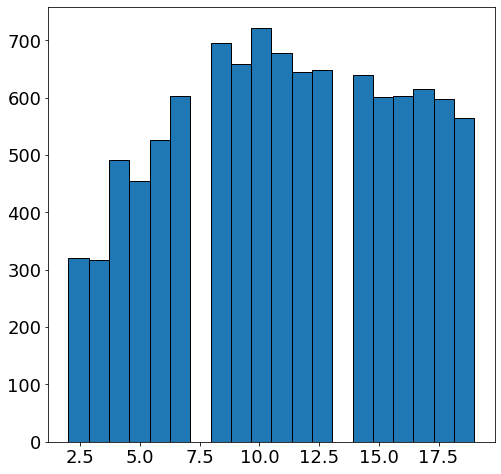

In [601]:
plt.hist(sorted_1, edgecolor='black', bins=20)
plt.show()

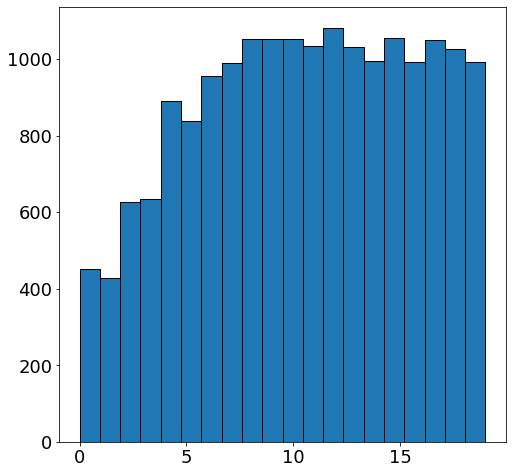

In [599]:
plt.hist(sorted_2, edgecolor='black', bins=20)
plt.show()

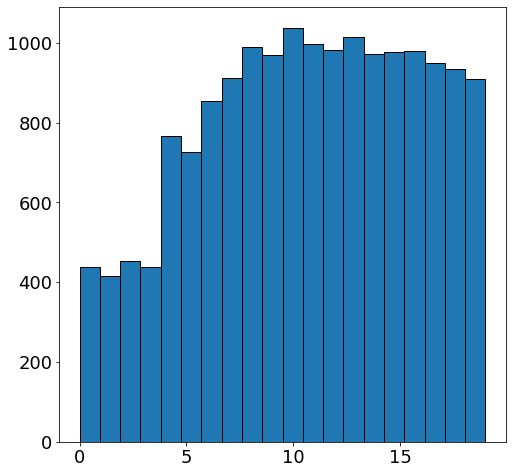

In [600]:
plt.hist(sorted_3, edgecolor='black', bins=20)
plt.show()